# Natural Language Processing - Text Classification - Naive Bayes

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements)
  * [Knowledge](#Knowledge)
  * [Python Modules](#Python-Modules)
  * [Data](#Data)
* [Fundation](#Fundation)
  * [Token, Types and Terms](#Token,-Types-and-Terms)
  * [Bayes-Theorem](#Bayes-Theorem)
  * [Maximum a posteriori](#Maximum-a-posteriori)
  * [Multinominal Naive Bayes](#Multinominal-Naive-Bayes)
   * [Document representation and model](#Document-representation-and-model)
   * [Smoothing](#Smoothing)
   * [Numerical stable version](#Numerical-stable-version)
* [Exercises](#Exercises)
  * [Exercise: Multinominal Naive Bayes](#Exercise:-Multinominal-Naive-Bayes)
    * [Frequencies of classes and terms](#Frequencies-of-classes-and-terms)
    * [Classification](#Classification)
  * [The Bernoulli model](#The-Bernoulli-model)
    * [Bernoulli - frequencies of classes and terms](#Bernoulli---frequencies-of-classes-and-terms)
    * [Bernoulli - Classification](#Bernoulli---Classification)
* [Literature](#Literature)
* [Licenses](#Licenses)
  * [Notebook License (CC-BY-SA 4.0)](#Notebook-License-(CC-BY-SA-4.0))
  * [Code License (MIT)](#Code-License-(MIT))

## Introduction

In this notebook, you will implement Naive Bayes learning algorithms for text classification.

You will work with the 20 Newsgroup dataset and explore how Bayes Theorem coupled with "naive Bayes" assumptions uses the features of a document to find the most probable class. We will also cover the use of log-likelihoods and smoothing for a more stable implementation.

At the end of this notebook you will have implemented two types of Naive Bayes classifiers, using the multinomial and Bernoulli model. The models differ in what types of features they extract from documents.

## Requirements

### Knowledge
* This notebook is based on Chapter 13 "Text classification and Naive Bayes" of Introduction to Information Retrieval. The book is published over at [https://nlp.stanford.edu/IR-book/information-retrieval-book.html](https://nlp.stanford.edu/IR-book/information-retrieval-book.html), see [MAN09](#MAN09) for a full citation. Study the chapter, in particular pp. 253 - 270 of the book, which corresponds to pp. 1 - 18 in the PDF.

* We'll be using the same corpus and some of the text preparation methods presented in sklearn's [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html), so you may want to keep the article handy.

### Python Modules

In [9]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

#from scipy.stats import multinomial

### Data
We're using the "20 Newsgroups" dataset as our corpus. It is a collection of over 10,000 newsgroup articles, each of which belongs to 1 of 20 classes.

In [10]:
basedir = '~/deep.TEACHING/data/newsgroups_dataset'

twenty_train = fetch_20newsgroups(data_home=basedir,
                                  subset='train',
                                  shuffle=True,
                                  random_state=42)

In [11]:
# use the test set not for training or model selection/hyperparamter tuning
twenty_test = fetch_20newsgroups(data_home=basedir,
                                  subset='test',
                                  shuffle=True,
                                  random_state=42)

## Fundation

#### Token, Types and Terms

Make sure you distinguish between **token**, **type** and **term** ([MAN09](#MAN09) ch. 2.2.1 'Tokenization'). A token is a word in a position in a document. A term is an item in the vocabulary. 
So we can take the sentence `The good, the bad and the ugly.`, split it into the tokens `the` `good` `the` `bad` `and` `the` `ugly` and extract the terms `the` `good` `bad` `and` `ugly` as a vocabulary.

- **Token**: An instance of a string in a text that is grouped together as a semantically meaningful unit.
- **Type**: The class of all tokens containing the same string. 
- **Term**: A normalized type (case, morphology, etc) that is used in the (Term-)Dictionary, e.g. `Häuser` $\rightarrow$ `haus`. Here: lemmatized and lowercased.


#### Bayes Theorem

The conditional probability $P(A=a|B=b)$  (short $P(a|b)$) tells us "What is the probability of $A$ being $a$ , given our knowledge of $B=b$?".       
Note: $A$ and $B$ are random variables and $a$ and $b$ are instances (concrete values) of the variables.

In text classification, we have a class $c$ from a set of classes $C$ and a document $d$. We're interested in $P(c|d)$,  $c$ is the correct class for the document, given our knowledge of the document (ground truth). 

Bayes' Theorem tells us that this probability can be computed as

$$
P(c|d) = \frac{P(c)P(d|c)}{P(d)}
$$
- $P(c)$ is the prior, i.e. the probability $c$ before we even consider the particular document $d$. 
- $P(d|c)$ is the likelihood. 
- $P(d)$ marginal likelihood, i.e. the probability of the evidence.



## Maximum a posteriori

$P(c|d)$ gives us the probability of class $c$ for the document $d$.
But computing this probability is *in general* untractable, because we can't compute the denominator of Bayes' Theorem: $P(d)=\sum_{c'}P(c')P(d|c')$.

However, often we are just interested in "what is the most probable class of a document". The process is called maximum a posteriori estimation or *map* for short.

$$
c_{map} = \underset{c' \in C}{\text{arg max}}[ P(c'|d) ]
$$

Because we don't care about the probability itself, we can drop the denominator $P(d)$ from the equation. It is constant across all classes, so dividing by it in every class won't change the $\text{arg max}$.

$$
P(c|d) \propto P(c) P(d|c)
$$

In the following we derive estimates for the two factors $P(c)$ and $P(d|c)$.

## Estimate of $P(c)$

$$
\hat P(c) = \frac{N_c}{N}
$$

with 
- $N_c$ the number of documents in the training corpus which are labeled as $c$.
- $N$ the number of all documents in the training corpus.

## Multinominal Naive Bayes

First, we'll give a representation for the document $d$. 

#### Document representation and model

In multinomial Naive Bayes, we represent a document $d$ with length $n_d$ as a sequence of tokens $\left< z^1,z^2,...z^{n_d} \right>$. The tokens $z^k$ are the words in the document at the corresponding positions $k$. 
A token $z^k$ correspond to a term $t^k$ that we have in the dictionary $V$ for classification.
We assume that the term probabilities are *conditionally independent* given the class. 
For example, seeing `hong` in a document doesn't change the probability on whether we'll see `kong`, given the class, e.g. `China`. 
Because of this *conditional independence assumption* this is called *naive* Bayes. 

*Stop words* etc. are not in the dictionary and are not used for classification.

Additionally, we assume that the positions of the words in the document provides no additional information.
That is we treat the document as a *bag of word*s. However, if a normalized token occurs several times, we count the same value several times:

$$
P(d|c) = P(\left< z_1,...,z_{n_d} \right>|c) \approx \prod_{1 \leq k \leq n_d} P(t^k|c)
= P({\bf t}_d| c)
$$

* $1 \leq k \leq n_d$ iterates over all $k$ (non-stop words etc.) tokens in the document.

$P(t|c)$ is estimated by the relative frequency of the term $t$  in all documents belonging to class $c$:

$$\hat P(t|c) = \frac{T_{ct}}{\sum_{t'\in V}T_{ct'}}$$ 

- $T_{ct}$ is the number of occurrences of $t$ in training documents from class
$c$, including multiple occurrences of a term in a document (*collection frequency*).
- ${\sum_{t'\in V}T_{ct'}}$ ist the number of all (relevant) token in all documents of class $c$

#### Exercise: Simple multinominal example

Different classes have different term distributions.
- Here with only two classes $0$ and $1$ and
- five terms in the lexicon.

We draw term-statistics from a multinominal distribution as training data:

<!--
Assumption: The term distribution $P( {\bf t} \mid c)$ is from a multinominal distribution: 

$$
P(t_0, t_1, \dots, t_n \mid c) = {n \choose n_1, \dotsc, n_k} p_1^{n_1} \dotsm p_k^{n_k}
$$

with the multinominal coefficient
$$
{n \choose n_1, \dotsc, n_k} = \frac{n!}{n_1!\dotsm n_k!}
$$-->

(array([0.0955, 0.4035, 0.188 , 0.0445, 0.2685]),
 array([0.29914286, 0.20114286, 0.09914286, 0.34771429, 0.05285714]))

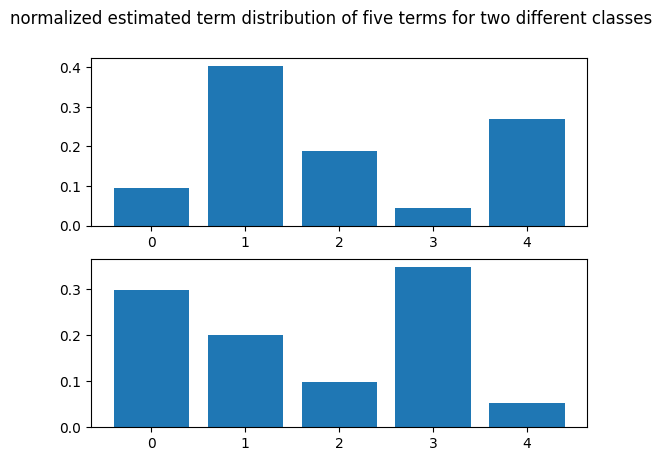

In [12]:
np.random.seed(42)
terms = range(5)

# true unknow distributions for the two classes 
# note they sum up to 1
pvals0 = [0.1, 0.4, 0.2, 0.05, 0.25] # class 0
pvals1 = [0.3, 0.2, 0.1, 0.35, 0.05] # class 1

# assume we have a corpus with
nb_terms_class_0 = 2000 # nb of terms in all documents of class 0
nb_terms_class_1 = 3500 # nb of terms in all documents of class 1

# generate the necessary statistics (counts) 
#   randomly from the true distributions 
T_c0 = np.random.multinomial(nb_terms_class_0, pvals0)
T_c1 = np.random.multinomial(nb_terms_class_1, pvals1)

# Maximum likelihood estimate of the true distributions
#   from the statistics 
T_c0_normalized = T_c0/np.sum(T_c0)
T_c1_normalized = T_c1/np.sum(T_c1)

fig, axs = plt.subplots(2)
fig.suptitle('normalized estimated term distribution of five terms for two different classes')
axs[0].bar(terms, T_c0_normalized)
axs[1].bar(terms, T_c1_normalized)
T_c0_normalized, T_c1_normalized, 

Assume we have 250 documents from class 0 and 200 documents from class 1
in our training corpus.

What is the prior distribtion $P(c')$ for $c' \in \{0, 1\}$??

With the naive Bayes classification model:

$$
\text{arg}\max_{c'} P(c'|d) = \text{arg}\max_{c'} P(c') P({\bf t}_d|c')
$$

and a document with six types (three different ones):
- term 0 two times,
- term 1 one time and 
- term 3 three times. 

**Task**

From what class is the document? 
- What do you expect from the distribution plot?
- What is $P({\bf t}_d|c')$ for $c' \in \{0, 1\}$? 
- What is the output of the classification decision?

In [14]:
# Your task:
P_t_c0 = None # p(d|c=0); d is represented as term counts   
P_t_c1 = None # p(d|c=1); 

In [17]:
# test for the likelihood values of the document to classify
np.testing.assert_almost_equal(P_t_c0, 3.181858385481873e-06) 
np.testing.assert_almost_equal(P_t_c1, 0.0007567100310787814) 

#### Smoothing

If a term–class combination did not occur in the training data, the estimate $\hat P({\bf t}_d|c)$ is zero. 

Adding one to the counts avoid this:

$$
\hat P(t|c) = \frac{T_{ct}+1}{\sum_{t'\in V}\left( T_{ct'}+1\right)} = \frac{T_{ct}+1}{\sum_{t'\in V}T_{ct'}+|V|}
$$

#### Numerical stable version

Instead of 
$$
c_{map} = \underset{c' \in C}{\text{argmax}}\left(\hat P(c') \cdot \prod_{1 \leq k \leq n_d} \hat P(t_k|c) \right)
$$

 we use the logarithm to get a numerically stable version: 

$$
c_{map} = \underset{c' \in C}{\text{argmax}}\left(\log \hat P(c') + \sum_{1 \leq k \leq n_d} \log\left( \hat P(t_k|c) \right) \right)
$$

# Exercises

### Bag of Words representation

Our documents are currently stored as lists of strings. For each document we have a string.

In [18]:
type(twenty_train.data), type(twenty_train.data[0])

(list, str)

In [19]:
# The first document in plain text
twenty_train.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In order to perform classification, we'll extract features from documents and transform them into feature vectors, as described in the following paragraph on [sklearn](#https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html):


> 1. Assign a fixed integer id $j$ to each term occurring in any document of the training set by building a dictionary from terms to integer indices $j$.
> 2. For each document $i$, count the number of occurrences of each term $t_j$ in the document and store it in `X[i, j]` as the value of feature $j$ where $j$ is the index of term $t$ in the dictionary.



The sklearn [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) performs tasks 1. and 2.:    

In [20]:
count_vectorizer = CountVectorizer(min_df=10, stop_words="english", token_pattern="[a-zA-Z]{2,}")

In [21]:
X_train = count_vectorizer.fit_transform(twenty_train.data)
y_train = twenty_train.target

print('vocabulary size: ',len(count_vectorizer.get_feature_names_out()))

vocabulary size:  14065


Here's a brief summary of the data layout and some of the members you'll have to access in the upcoming sections. For a full reference, check out the sklearn article [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

`X_train` : <font color='#202340'>*sparse matrix, shape = (n_documents, n_terms)*</font>        
A document-term feature matrix that stores the count of each term in each document. Each row represents a document, each column represents a term. `X_train[i,j]` is the number of times term $j$ occurs in document $i$.
$j$ is the index in the term dictionary.

`y_train` : <font color='#202340'>*array, shape = (n_documents,)*</font>

The target vector which indicates the class of each document. Each element in `y_train` is an integer <span style='white-space:nowrap'>${0,1, ... ,n_{classes}-1}$</span>. `y_train[i]` is the class of document with index $i$.

In [22]:
num_documents, num_terms = X_train.shape
first_document = X_train[0,:]

In [23]:
# Classes of the first 10 documents
y_train[0:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [24]:
y_train==0

array([False, False, False, ..., False, False, False])

In [25]:
# The names of each class
print('\n'.join(twenty_train.target_names))

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


In [26]:
# The learned vocabulary, index in the list corresponds to index of the term
print('\n'.join(count_vectorizer.get_feature_names_out()[800:810]))
print('vocabulary size: ',len(count_vectorizer.get_feature_names_out()))

athletics
athos
ati
atkins
atl
atlanta
atlantaga
atlantic
atlas
atlastele
vocabulary size:  14065


###  Exercise: Multinominal Naive Bayes


Implement for the Multinominal Naive Bayes Classifier `NaiveBayesMultinomial`
the classmethod `estimate_probabilities` and the method `predict_sentence`: 

In [31]:
class NaiveBayesMultinomial():
    
    def __init__(self):
        # transform text documents into feature vectors
        self.count_vectorizer = CountVectorizer(min_df=10, stop_words="english", 
                                   token_pattern="[a-zA-Z]{2,}")
        
    def transform(self, corpus):
        X = self.count_vectorizer.transform(corpus.data)
        y = corpus.target
        return X, y
        
    def fit_transform(self, twenty_train):
        X_train = self.count_vectorizer.fit_transform(twenty_train.data)
        y_train = twenty_train.target
        # learn frequency of classes and terms given classes
        self.priors, self.cond_probs = self.estimate_probabilities(X_train, y_train)
        #self.twenty_train = twenty_train
        self.target_names = twenty_train.target_names
        return X_train, y_train
        
    @classmethod
    def estimate_probabilities(cls, X, y):
        '''
        Learning process. 
    
        Computes the prior probability of each class P(c)
        and the smoothed conditional probability of each term given the class
        for all classes and terms P(t|c)
        Documents in X is the document representation (counts)
        for the multinomial model.
    
        Parameters:
            X : sparse matrix ; shape = (num_documents, num_terms)
                a document-term matrix e.g. X_train
            y : np.ndarray ; shape = (num_classes)
                the target vector
        Returns:
            P(c) : np.ndarray ; shape = (num_classes)
            frequency of each class [0..1]
            P(t|c) : np.ndarray ; shape = (num_classes, num_terms)
                conditional probability of each term given the class
                for all terms and classes
        '''
        # Uses smoothing
        priors, cond_probs = None, None
        raise NotImplementedError()
        return priors, cond_probs

    
    def predict(self, text):
        '''
        Parameters:
            text (str): A text a string to classify
    
        Returns: 
            str, name of the most likely class. names are listed in
            self.target_names
        '''
        raise NotImplementedError()
        return self.target_names

In [33]:
# SOLUTION
def predict(self, sentence):
        sentence_tf = self.count_vectorizer.transform([sentence]).toarray()
        log_likelihood = sentence_tf @ np.log(self.cond_probs.T)
        cmap = np.argmax(np.log(self.priors) + log_likelihood).item()
        return self.target_names[cmap]

NaiveBayesMultinomial.predict = predict

In [34]:
clf = NaiveBayesMultinomial()
clf.fit_transform(twenty_train)

(<11314x14065 sparse matrix of type '<class 'numpy.int64'>'
 	with 1027803 stored elements in Compressed Sparse Row format>,
 array([7, 4, 4, ..., 3, 1, 8]))

In [35]:
priors, cond_probs = clf.estimate_probabilities(X_train,y_train)

In [36]:
num_classes = len(twenty_train.target_names)
num_terms = len(count_vectorizer.vocabulary_)

# test shapes
assert priors.shape == (num_classes,)
assert cond_probs.shape == (num_classes, num_terms)

# test probability distribution
np.testing.assert_almost_equal(priors.sum(), 1.0)
np.testing.assert_allclose(cond_probs.sum(axis=1), 1.0)

# no zero-frequencies
assert np.all(priors > 0)
assert np.all(cond_probs > 0)

# test some vlaues
np.testing.assert_allclose(cond_probs[[3,10]][:,[0,28,442,1365]], np.array([[2.23369729e-04, 1.31393959e-05, 1.31393959e-05, 1.31393959e-05],
        [3.04723210e-05, 1.01574403e-05, 3.04723210e-05, 1.01574403e-05]]))

# ensure classifier uses the same probabilities
assert np.array_equal(priors, clf.priors)
assert np.array_equal(cond_probs, clf.cond_probs)

In [37]:
assert 'sci.med' == clf.predict('patient hospital doctor moon' * 100), msg
assert 'sci.space' == clf.predict('planet jupiter moon ' * 10), msg
assert 'alt.atheism' == clf.predict('god atheist '), msg

8470 [[ -9.78294571  -9.9209836  -10.29900894  -8.53184532  -8.56387124
   -8.77891302  -9.39107734  -8.87608749  -9.44162404  -9.88304247
   -9.70554461  -8.41323645  -9.03248881  -8.26964424  -9.25314121
   -8.7960174  -10.51359727  -9.88078902 -10.20690148 -10.09471379]]
8471 [[ -9.19515905 -10.20866567 -10.99215612  -9.85360116 -11.12882059
  -11.55150174  -9.20875578  -8.78907611  -7.83218612 -10.17072454
  -10.11100972 -11.05229378 -10.53656621 -10.38990777  -9.60981615
  -10.87545894 -11.61220956 -11.82669917 -10.49458355 -10.5001789 ]]
8472 [[-11.39238363 -11.30727796 -12.09076841 -11.23989552 -11.12882059
  -11.55150174 -11.00051525 -11.27398276 -11.23338351 -11.26933683
   -7.40295952 -11.74544096 -11.22971339 -10.38990777 -11.5557263
   -8.92954879 -11.61220956 -11.82669917 -11.59319584 -11.19332608]]
8473 [[-9.60062416 -7.8107704  -9.78818332 -9.29398537 -8.8262355  -9.06659509
  -7.38959734 -7.87278538 -7.90117899 -9.07211225 -6.94342719 -9.10638363
  -9.15027185 -8.230423

9683 [[ -8.7533263   -8.31154569  -8.35309879  -7.30806989  -7.99332638
  -10.45288945  -7.66831074  -9.8876884   -9.44162404 -10.17072454
   -8.60693233 -10.13600305  -8.74480674  -9.87908215  -9.25314121
   -8.92954879  -7.80554707  -7.71582531  -7.87962377  -8.79543081]]
9684 [[ -9.44647348 -11.30727796 -12.09076841 -10.14128324 -11.12882059
  -11.55150174 -10.30736807  -9.48222329 -10.54023632  -9.65989892
  -11.49730408  -9.10638363 -11.22971339 -10.38990777  -9.94628839
   -9.77684665  -9.82045009 -11.82669917 -10.20690148 -10.09471379]]
9685 [[ -9.60062416 -10.61413078 -12.09076841 -11.23989552 -11.12882059
  -11.55150174 -11.00051525 -10.17537047 -11.23338351 -10.57618965
  -10.3986918   -9.1804916  -11.22971339 -11.48852006 -10.86257912
   -9.48916458  -9.82045009 -11.82669917 -11.59319584  -8.9961015 ]]
9686 [[-7.17287592 -7.35603424 -8.26212701 -7.28865181 -7.43994114 -7.34680912
  -8.22792653 -7.03987626 -7.19033224 -6.78070046 -6.97551551 -6.84760116
  -6.84768675 -6.89340

10856 [[-11.39238363 -11.30727796  -8.37719634 -10.14128324 -11.12882059
  -11.55150174 -11.00051525 -11.27398276 -10.13477122 -11.26933683
  -11.49730408 -11.05229378 -10.53656621 -10.79537288 -10.86257912
  -11.56860612  -9.82045009 -11.82669917 -11.59319584 -11.19332608]]
10857 [[ -7.48036062  -9.22783642 -12.09076841 -10.14128324 -10.43567341
  -10.85835456  -9.90190296  -9.32807261  -6.94292406  -7.44069543
   -9.01239743 -11.05229378  -9.62027547 -10.1022257   -9.94628839
  -10.18231176 -10.51359727 -11.13355199  -7.66137021  -9.40156661]]
10858 [[ -7.34933236  -9.9209836   -7.96363403  -9.04267095 -10.03020831
  -10.85835456 -11.00051525 -11.27398276  -8.01450768 -11.26933683
  -11.49730408  -9.44285587  -9.62027547 -11.48852006 -11.5557263
  -11.56860612 -10.91906238 -11.82669917 -11.59319584 -10.5001789 ]]
10859 [[ -9.44647348 -10.61413078  -8.99972596 -10.54674834 -11.12882059
  -10.45288945  -9.61422089 -10.17537047 -11.23338351 -11.26933683
  -11.49730408 -11.05229378  -9.1

11697 [[-11.39238363 -10.61413078 -10.99215612 -11.23989552 -11.12882059
  -11.55150174 -11.00051525 -10.58083558 -11.23338351 -11.26933683
  -11.49730408 -11.74544096 -10.53656621  -9.87908215 -10.86257912
  -11.56860612 -11.61220956 -11.82669917 -11.59319584 -10.5001789 ]]
11698 [[ -7.34933236 -11.30727796 -12.09076841 -11.23989552 -11.12882059
  -11.55150174 -11.00051525  -9.66454485 -10.54023632 -11.26933683
  -10.3986918  -11.74544096 -11.22971339  -9.40907852 -10.86257912
  -10.46999383 -11.61220956 -11.82669917 -10.90004866  -8.62837672]]
11699 [[ -8.68433343  -8.08840214  -9.52581905  -8.53184532  -8.35623187
   -7.37711447 -11.00051525  -8.44076942  -8.59432618 -10.17072454
   -9.88786617  -8.34424358  -8.39650004  -8.05453286  -7.97220736
   -7.52555485  -8.83962083  -8.8309669   -7.49885128  -8.62837672]]
11700 [[ -8.39665135  -8.82237131 -10.4813305   -9.29398537  -8.93159602
   -8.84345154  -9.61422089  -9.32807261  -9.15394196  -9.65989892
  -10.8041569   -9.10638363  -9.

12828 [[ -9.44647348 -11.30727796 -12.09076841 -11.23989552 -10.43567341
  -11.55150174 -11.00051525 -11.27398276 -10.54023632 -11.26933683
  -11.49730408  -9.10638363 -11.22971339  -7.9920125  -11.5557263
  -10.87545894 -11.61220956 -10.0349397   -8.95413851 -11.19332608]]
12829 [[ -9.60062416  -8.66822063 -12.09076841  -9.44813605 -11.12882059
  -11.55150174  -9.61422089 -10.17537047 -11.23338351 -10.57618965
  -10.3986918  -11.74544096 -10.53656621  -9.54260991 -11.5557263
  -11.56860612 -11.61220956  -8.93632741 -10.49458355 -10.5001789 ]]
12830 [[-11.39238363  -8.82237131 -12.09076841 -11.23989552 -11.12882059
  -10.16520738 -11.00051525 -11.27398276 -11.23338351 -11.26933683
  -11.49730408 -11.74544096 -11.22971339 -11.48852006 -11.5557263
  -11.56860612 -11.61220956 -11.82669917 -10.49458355 -11.19332608]]
12831 [[-10.69923645 -11.30727796 -12.09076841 -11.23989552 -11.12882059
  -11.55150174 -10.30736807 -11.27398276 -11.23338351  -8.96675174
  -11.49730408 -10.3591466  -11.229

#### Test against sklearn's multinomial Naive Bayes

As another test, compare your implementation against sklearn's multinomial Naive Bayes classifier:

In [38]:
from sklearn.naive_bayes import MultinomialNB
X_test, y_test = clf.count_vectorizer.transform(twenty_test.data), twenty_test.target
sk_nb = MultinomialNB().fit(X_train, y_train)

In [39]:
# use a subset of samples
samples = list(range(50))

sk_pred = sk_nb.predict(X_test[samples,:])
my_pred = [clf.predict(twenty_test.data[i]) for i in samples]
my_pred = np.array(list(twenty_train.target_names.index(c) for c in my_pred))

In [40]:
print('Our predictions: {}'.format(my_pred))
print('Sklearns predictions: {}'.format(sk_pred))
print('Match: {}'.format(np.mean(my_pred == sk_pred)))

Our predictions: [ 7  1  0 17  0 13 15  5  5  1  1  1 17  8 15  3  4  1  6 16 13  6 17 14
  3  8 11  7  7  3  1  1  4  3 14  1  9  4  4  1 17  1  8  1 11  1 14  3
 11 11]
Sklearns predictions: [ 7  1  0 17  0 13 15  5  5  1  1  1 17  8 15  3  4  1  6 16 13  6 17 14
  3  8 11  7  7  3  1  1  4  3 14  1  9  4  4  1 17  1  8  1 11  1 14  3
 11 11]
Match: 1.0


### Hyperparametertuning 

If you want to improve the classification performance 
you can tune e.g. the text proprocessing. 

However, don't use the test set for training or model selection/hyperparamter tuning.
Only then you get an unbiased estimate for the performance of the classifier. 

You have to split out an validation set from the training set for hyperparameter tuning.

## The Bernoulli model

So far we've dealt with the **multinomial model** which models a document as the vector of its tokens $\left< z^1, z^2, \dots z^{n_d} \right>, z^k \in V$.

Now we turn to the Bernoulli model which chooses a binary representation:

$$
d = \left< e_1, e_2, ..., e_M \right> , e_i \in \{0,1\}
$$

Each indicator $e_j$ represents a term of the vocabulary. $e_j$ is 1 if the $j$-th term is present in the document, or 0 if it is absent. It doesn't matter how often a term is present in a document.

We can again use a [CountVectorizer](#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to transform documents into this binary feature vector when we pass the argument `binary=True` to its constructor: 

`CountVectorizer(binary=True, ...)`.

### Bernoulli - frequencies of classes and terms

The prior is computed the same way as before, with $N_c$ as the number of documents in class $c$ and $N$ as the total number of documents:

$$
\hat P(c) = \frac{N_c}{N}
$$

To estimate the conditional probability, we use the 
fraction of documents in $c$ where the term $t$ is present.

$$
\hat{P}(e_j=1|c) = \frac{N_{ce_j^{t}} + 1}{N_c + 2}
$$
where
* $e_j$ is the indicator that the term $t_j$ is present ($e_j = 1$) or absent ($e_j=0$)
* the numerator is $N_{ce_j^t}$, the count of documents in $c$ where term $t_j$ is present. We use "$+ 1$" for smoothing.
* the denominator is the total count of documents in $c$, with "$+ 2$" for smoothing. 2 times "$+1$" for ($e_j = 0$) and ($e_j = 1$).


Note: The probability the the term $t$ is not present is therefore

$$
\hat{P}(e_j = 0  \mid c) = \frac{N_{c e_j^{\lnot t}} + 1}{N_c + 2}
$$

which follows from:
$$
\hat{P}(e_j=1 \mid c) + \hat{P}(e_j=0 \mid c) = 1
$$

and

$$
N_{c e_j^t}  + N_{ce_j^{\lnot t}} = N_c 
$$


### Classification

In the Bernoulli model we explicitly factor in the absence of a term in the score for a class. 
Therefore, the equation for the likelihood $P(d|c)$ becomes

$$
P(d|c) \approx \prod_{j \in \{1, \dots |V|\}} \hat{P}(e_j \mid c)
$$

where
* $t_j \in V$ iterates over all terms in the vocabulary
* $\hat{P}(e_j \mid c)$ is
  * $\hat{P}(e_j=1|c)$ if the $j$-th term is present in the document or 
  * $\hat{P}(e_j=0 \mid c) = 1 - \hat{P}(e_j=1 \mid c)$ if the term is absent.
  
Plugging this into the equation for the best class $c_{map}$ analog to the
multinominal model:

$$
c_{map} = \text{arg} \max_{c \in C} \left( \hat{P}(c) \cdot \prod_{1 \leq i \leq |V|} \hat{P}(e_i|c) \right)
$$
- $|V|$ is the number of terms in the term dictionary.

resp. the numerically stable version using the logarithm:

$$
c_{map} = \text{arg} \max_{c \in C}  \left( \log\left(\hat{P}(c)\right) + \sum_{1 \leq i \leq |V|} \log\left(\hat{P}(e_i|c)\right) \right)
$$



#### Bernoulli Model simple example

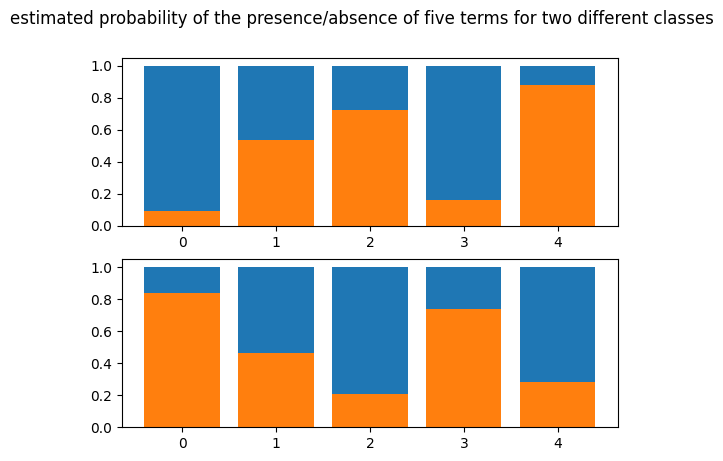

In [41]:
np.random.seed(42)
terms = range(5)

# true unknown Bernoulli probabilities for the presence of five terms
pvals0 = [0.1, 0.6, 0.7, 0.15, 0.9] # class 0
pvals1 = [0.8, 0.42, 0.2, 0.75, 0.25] # class 1

nb_documents_per_class = np.array([250., 200.])

# generate the necessary statistics randomly from the true distributions 
d0 = np.random.binomial(nb_documents_per_class[0], pvals0)
d1 = np.random.binomial(nb_documents_per_class[1], pvals1)

# Maximum likelihood estimate:
# Estimate the distribution parameters from the statistics 
p_t_c0 = d0/nb_documents_per_class[0]
p_t_c1 = d1/nb_documents_per_class[1]

fig, axs = plt.subplots(2)
fig.suptitle('estimated probability of the presence/absence of five terms for two different classes')
axs[0].bar(terms, [1.]*5)
axs[0].bar(terms, p_t_c0)
axs[1].bar(terms, [1.]*5)
axs[1].bar(terms, p_t_c1);
# orange is the probability of presence
# blue is the probability of absence

With the Bernoulli classification model (here: no smoothing - no logarithm):

$$
c_{map} = \text{arg} \max_{c' \in C} \left( \hat{P}(c') \cdot \prod_{1 \leq j \leq M} \hat{P}(e_j|c') \right)
$$

and a document with six terms (three different ones):
- term 0 two times,
- term 1 one time and 
- term 3 three times. 

**Task**

From what class is the document?

- What do you expect from the distribution plot?
- What is $ P(d|c') \approx \prod_{1 \leq j \leq M} \hat{P}(e_j|c')$ for $c' \in \{0, 1\}$? 
- What is the output of the classification decision?

In [42]:
p_d_c0 = None # P(d|c'=0)
p_d_c1 = None # P(d|c'=1)

In [44]:
# test your result
# this are the nonsmoothed values
np.testing.assert_almost_equal(p_d_c0, 0.00026131415)
np.testing.assert_almost_equal(p_d_c1, 0.1632665034)

# for classification take also the prior into account!

In [45]:
class NaiveBayesBernoulli():
    
    def __init__(self):
        self.count_vectorizer = CountVectorizer(binary=True, 
                                                min_df=10, 
                                                stop_words="english", 
                                                token_pattern="[a-zA-Z]{2,}")
        
        
    def fit_transform(self, corpus):   
        X_train = self.count_vectorizer.fit_transform(corpus.data)
        y_train = corpus.target
        self.priors, self.cond_probs = self.get_bernoulli_probabilities(X_train, y_train)
        self.corpus = corpus
        self.target_names = corpus.target_names
    
    @classmethod
    def get_bernoulli_probabilities(cls, X, y):
        '''
        Learning process of P(c) and P(t|c) for all terms and classes.
        Documents in X are generated with the Bernoulli model.
        '''
        raise NotImplementedError()
        return priors, cond_probs
    
        
        
    def predict(self, text):
        '''
        Transforms the sentence according to the Bernoulli model and 
        returns the name of the best class.
    
        Parameters:
            text (str): A stext string to classify
    
        Returns: 
            str, name of the most likely class. names are listed in
               self.target_name
        '''
        raise NotImplementedError()
        return target_name[i]


Verify your implementation.

In [47]:
clf_bernoulli = NaiveBayesBernoulli()
clf_bernoulli.fit_transform(twenty_train)

In [48]:
pc, ptc = clf_bernoulli.priors, clf_bernoulli.cond_probs
num_classes = len(twenty_train.target_names)
num_terms = len(clf_bernoulli.count_vectorizer.vocabulary_)

# test shapes
assert pc.shape == (num_classes,)
assert ptc.shape == (num_classes, num_terms)

# test probability distribution
np.testing.assert_almost_equal(pc.sum(), 1.0)

# test smoothing
assert np.all(ptc > 0), "Not all conditional probabilites are greater than zero. Did you apply smooothing?"

# test some values
np.testing.assert_almost_equal(ptc[[3,10]][:,[0, 828, 562, 1365]].sum(), 
                               0.045243333034030705)

As a test, compare your implementation against SKLearn's Naive Bayes Bernoulli classifier:

In [51]:
from sklearn.naive_bayes import BernoulliNB
X_test, y_test = clf_bernoulli.count_vectorizer.transform(twenty_test.data), twenty_test.target
sk_nb = BernoulliNB().fit(X_train, y_train)

In [52]:
# use a subset of samples
samples = list(range(50))

sk_pred = sk_nb.predict(X_test[samples,:])
my_pred = [clf_bernoulli.predict(twenty_test.data[i]) for i in samples]
my_pred = np.array(list(twenty_train.target_names.index(c) for c in my_pred))

In [53]:
print('Our predictions: {}'.format(my_pred))
print('Sklearns predictions: {}'.format(sk_pred))
print('Match: {}'.format(np.mean(my_pred == sk_pred)))

Our predictions: [ 4  1  0 17  0 13  6  2  5  1  2  1 17  8 15  3  4  6  6  6 17  6  0 14
  3 13 11  7  7  3  1  1  4  3 14  1  9  6  6  1 17  1  8  1 11  1 14  3
  3 11]
Sklearns predictions: [ 4  1  0 17  0 13  6  2  5  1  2  1 17  8 15  3  4  6  6  6 17  6  0 14
  3 13 11  7  7  3  1  1  4  3 14  1  9  6  6  1 17  1  8  1 11  1 14  3
  3 11]
Match: 1.0


## Summary and Outlook

In this notebook you've implement classifiers for Naive Bayes classification, one using the multinomial model and another using the Bernoulli model.

Manning<sup>[[MAN09]](#MAN09)</sup> presents the implications of the model differences on p. 268, so perhaps you may want to construct some example documents to exhibit those effects.

## Literature
<table>
    <tr>
        <td>
            <a name="MAN09"></a>[MAN09]
        </td>
        <td>
            Introduction To Information Retrieval
Christopher Manning-Prabhakar Raghavan-Hinrich Schütze - Cambridge University Press - 2009<br>At the time of writing [Feb 28 2019] Online version available at <a href='https://nlp.stanford.edu/IR-book/information-retrieval-book.html'>https://nlp.stanford.edu/IR-book/information-retrieval-book.html</a>
        </td>
    </tr>
    <tr>
        <td>
            <a name="SK11"></a>[SK11]
        </td>
        <td> "Working With Text Data" [Online, accessed Feb 28 2019]. Available: <a href='https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html'>https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html</a>
            Scikit-learn: Machine Learning in Python
Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay; 12(Oct):2825−2830, 2011.
        </td>
    </tr>
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Naive Bayes_ <br/>
by _Diyar Oktay_, _Christian Herta_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 _Diyar Oktay_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.